In [3]:
!nvidia-smi

Fri Jul 11 17:33:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 59%   51C    P2            105W /  285W |    7279MiB /  12282MiB |     68%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import threading
from torch.distributions import Normal

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import pybullet_envs
import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from skimage.transform import resize
from skimage.color import rgb2gray
from subprocess import check_output
from IPython.display import display, HTML

LEAVE_PRINT_EVERY_N_SECS = 300
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [5]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [6]:
torch.cuda.is_available()

True

In [7]:
def get_make_env_fn(**kargs):
    def make_env_fn(env_name, seed=None, render=None, record=False,
                    unwrapped=False, monitor_mode=None, 
                    inner_wrappers=None, outer_wrappers=None):
        mdir = tempfile.mkdtemp()
        env = None
        if render:
            try:
                env = gym.make(env_name, render=render)
            except:
                pass
        if env is None:
            env = gym.make(env_name)
        if seed is not None: env.seed(seed)
        env = env.unwrapped if unwrapped else env
        if inner_wrappers:
            for wrapper in inner_wrappers:
                env = wrapper(env)
        env = wrappers.Monitor(
            env, mdir, force=True, 
            mode=monitor_mode, 
            video_callable=lambda e_idx: record) if monitor_mode else env
        if outer_wrappers:
            for wrapper in outer_wrappers:
                env = wrapper(env)
        return env
    return make_env_fn, kargs

In [8]:
def get_videos_html(env_videos, title, max_n_videos=4):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [9]:
def get_gif_html(env_videos, title, subtitle_eps=None, max_n_videos=4):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '7',
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm',
                 '-crf', '20',
                 '-vf', 'scale=512:-1',
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert',
                 '-coalesce',
                 '-delay', '7',
                 '-loop', '0',
                 '-fuzz', '2%',
                 '+dither',
                 '-deconstruct',
                 '-layers', 'Optimize',
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        prefix = 'Trial ' if subtitle_eps is None else 'Episode '
        sufix = str(meta['episode_id'] if subtitle_eps is None \
                    else subtitle_eps[meta['episode_id']])
        strm += html_tag.format(prefix + sufix, encoded.decode('ascii'))
    return strm


In [10]:
class RenderUnit8(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    def render(self, mode ='rgb_array'):
        frame = self.env.render(mode= mode)
        return frame.astype(np.unit8)

# DDPG

In [11]:
class FCQV(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims = (32, 32), 
                 activation_fc = F.relu):
        super(FCQV, self).__init__()
        self.activation_fc = activation_fc 

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) -1): 
            in_dim = hidden_dims[i]
            if i == 0: 
                in_dim += output_dim 
            hidden_layer = nn.Linear(in_dim, hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state, action):
        x, u = state, action 

        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device = self.device, dtype = torch.float32)
            x = x.unsqueeze(0)

        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, device = self.device, dtype = torch.float32)
            u = u.unsqueeze(0)
        
        return x, u 
    

    def forward(self, state, action):
        x, u = self._format(state, action)
        x = self.activation_fc(self.input_layer(x))
        for i, hidden_layer in enumerate(self.hidden_layers):
            if i == 0:
                x = torch.cat((x,u), dim = 1)
            x = self.activation_fc(hidden_layer(x))

        return self.output_layer(x)
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [12]:
class FCDP(nn.Module):
    def __init__(self,
                 input_dim, 
                 action_bounds, 
                 hidden_dims  = (32, 32), 
                 activation_fc = F.relu, 
                 out_activation_fc = F.tanh
                 ):
        super(FCDP, self).__init__()
        self.activation_fc = activation_fc 
        self.out_activation_fc = out_activation_fc 
        self.env_min , self.env_max = action_bounds 

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_lyaers = nn.ModuleList()

        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_lyaers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], len(self.env_max))

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device (device)
        self.to(device)


        self.env_min = torch.tensor(self.env_min, 
                                    device = self.device,
                                    dtype = torch.float32)
        self.env_max = torch.tensor(self.env_max, 
                                    device = self.device, 
                                    dtype = torch.float32)
        

        self.nn_min = self.out_activation_fc(
            torch.Tensor([float('-inf')]).to(self.device)
        )
        self.nn_max = self.out_activation_fc(
            torch.Tensor([float('inf')]).to(self.device)
        )

        self.rescale_fn = lambda x: (x - self.nn_min)*(self.env_max - self.env_min)/ \
                                    (self.nn_max - self.nn_min) + self.env_min 
        
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x
    
    def forward(self, state):
        x = self._format(state)

        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_lyaers: 
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        x = self.out_activation_fc(x)

        return self.rescale_fn(x)
        

In [13]:
class ReplayBuffer():
    def __init__(self, max_size = 10_000,
                 batch_size = 64):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)


        self.max_size = max_size 
        self.batch_size = batch_size 
        self._idx = 0 
        self.size = 0 
    def store(self, sample):
        s, a, r, p, d = sample 
        self.ss_mem[self._idx] = s 
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r 
        self.ps_mem[self._idx] = p 
        self.ds_mem[self._idx] = d 

        self._idx += 1
        self._idx = self._idx % self.max_size 

        self.size += 1 
        self.size = min(self.size, self.max_size)
    def sample(self, batch_size = None):
        if batch_size == None: 
            batch_size = self.batch_size 
        idxs = np.random.choice(
            self.size, batch_size, replace = False
        )

        experiences = np.vstack(self.ss_mem[idxs]), \
                        np.vstack(self.as_mem[idxs]), \
                        np.vstack(self.rs_mem[idxs]), \
                        np.vstack(self.ps_mem[idxs]), \
                        np.vstack(self.ds_mem[idxs])
        return experiences 
        

    def __len__(self):
        return self.size 

In [14]:
class GreedyStrategy():
    def __init__(self, bounds):
        self.low, self.high = bounds 
        self.ratio_noise_injected = 0 
    def select_action(self, model, state):
        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()
        action = np.clip(greedy_action, self.low, self.high)
        return np.reshape(action, self.high.shape)

In [15]:
class GreedyStrategy():
    def __init__(self, bounds):
        self.low, self.high = bounds
        self.ratio_noise_injected = 0

    def select_action(self, model, state):
        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()

        action = np.clip(greedy_action, self.low, self.high)
        return np.reshape(action, self.high.shape)

In [16]:
class NormalNoiseStrategy():
    def __init__(self, bounds, exploration_noise_ratio = 0.1):
        self.low, self.high = bounds 
        self.exploration_noise_ratio = exploration_noise_ratio 
        self.ratio_noise_injected = 0 
    def select_action(self, model, state, max_exploration = False):
        if max_exploration: 
            noise_scale = self.high 
        else: 
            noise_scale = self.exploration_noise_ratio*self.high 
        
        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()

        noise = np.random.normal(loc = 0, scale = noise_scale, size = len(self.high))
        noisy_action = greedy_action + noise 
        action = np.clip(noisy_action, self.low, self.high)

        self.ratio_noise_injected = np.mean(abs((greedy_action - action)/(self.high - self.low)))
        return action 
    

In [17]:
class NormalNoiseStrategy():
    def __init__(self, bounds, exploration_noise_ratio=0.1):
        self.low, self.high = bounds
        self.exploration_noise_ratio = exploration_noise_ratio
        self.ratio_noise_injected = 0

    def select_action(self, model, state, max_exploration=False):
        if max_exploration:
            noise_scale = self.high
        else:
            noise_scale = self.exploration_noise_ratio * self.high

        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()

        noise = np.random.normal(loc=0, scale=noise_scale, size=len(self.high))
        noisy_action = greedy_action + noise
        action = np.clip(noisy_action, self.low, self.high)
        
        self.ratio_noise_injected = np.mean(abs((greedy_action - action)/(self.high - self.low)))
        return action

In [18]:
class DDPG():
    def __init__(self, 
                 replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn, 
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr, 
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau):
        self.replay_buffer_fn = replay_buffer_fn

        self.policy_model_fn = policy_model_fn
        self.policy_max_grad_norm = policy_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        
        self.value_model_fn = value_model_fn
        self.value_max_grad_norm = value_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr

        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn

        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = tau

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        argmax_a_q_sp = self.target_policy_model(next_states)
        max_a_q_sp = self.target_value_model(next_states, argmax_a_q_sp)
        target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)
        q_sa = self.online_value_model(states, actions)
        td_error = q_sa - target_q_sa.detach()
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model.parameters(), 
                                       self.value_max_grad_norm)
        self.value_optimizer.step()

        argmax_a_q_s = self.online_policy_model(states)
        max_a_q_s = self.online_value_model(states, argmax_a_q_s)
        policy_loss = -max_a_q_s.mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_policy_model.parameters(), 
                                       self.policy_max_grad_norm)        
        self.policy_optimizer.step()

    def interaction_step(self, state, env):
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        action = self.training_strategy.select_action(self.online_policy_model, 
                                                      state, 
                                                      len(self.replay_buffer) < min_samples)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += self.training_strategy.ratio_noise_injected
        return new_state, is_terminal
    
    def update_networks(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model.parameters(), 
                                  self.online_value_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_policy_model.parameters(), 
                                  self.online_policy_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
        action_bounds = env.action_space.low, env.action_space.high
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_value_model = self.value_model_fn(nS, nA)
        self.online_value_model = self.value_model_fn(nS, nA)
        self.target_policy_model = self.policy_model_fn(nS, action_bounds)
        self.online_policy_model = self.policy_model_fn(nS, action_bounds)
        self.update_networks(tau=1.0)
        self.value_optimizer = self.value_optimizer_fn(self.online_value_model, 
                                                       self.value_optimizer_lr)        
        self.policy_optimizer = self.policy_optimizer_fn(self.online_policy_model, 
                                                         self.policy_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn(action_bounds)
        self.evaluation_strategy = evaluation_strategy_fn(action_bounds)
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model.load(experiences)
                    self.optimize_model(experiences)

                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_networks()

                if is_terminal:
                    gc.collect()
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_policy_model, env)
            self.save_checkpoint(episode-1, self.online_policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:07}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(eval_policy_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=4):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=2, max_n_videos=2):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.online_policy_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def demo_progression(self, title='{} Agent progression', max_n_videos=4):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.online_policy_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [19]:
ddpg_results = []
best_agent, best_eval_score = None, float("-inf")

for seed in SEEDS: 
    environment_settings = {
        "env_name": "Pendulum-v0", 
        "gamma": 0.99, 
        "max_minutes": 20, 
        "max_episodes": 500, 
        "goal_mean_100_reward": -150
    }

    policy_model_fn = lambda nS, bounds: FCDP(nS, bounds, hidden_dims=(256, 256))
    policy_max_grad_norm = float("inf")
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr = lr)
    policy_optimizer_lr = 0.0003 

    value_model_fn = lambda nS, nA: FCQV(nS, nA, hidden_dims=(256, 256))
    value_max_grad_norm = float("inf")
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr = lr)
    value_optimizer_lr = 0.0003

    training_strategy_fn = lambda bounds: NormalNoiseStrategy(bounds, exploration_noise_ratio=0.1)
    evaluation_strategy_fn = lambda bounds: GreedyStrategy(bounds)

    replay_buffer_fn = lambda: ReplayBuffer(max_size=100000, batch_size=256)
    n_warmup_batches = 5
    update_target_every_steps = 1
    tau = 0.005
    
    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()

    agent = DDPG(replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn, 
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr, 
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    ddpg_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
ddpg_results = np.array(ddpg_results)
_ = BEEP()


el 00:06:54, ep 0000, ts 0000200, ar 10 -1296.7±000.0, 100 -1296.7±000.0, ex 100 0.3±0.0, ev -1391.7±000.0
el 00:11:39, ep 0116, ts 0023400, ar 10 -145.0±068.9, 100 -175.8±174.1, ex 100 0.0±0.0, ev -146.2±096.7
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score -127.57±80.83 in 329.94s training time, 711.49s wall-clock time.

el 00:00:00, ep 0000, ts 0000200, ar 10 -1373.7±000.0, 100 -1373.7±000.0, ex 100 0.3±0.0, ev -1743.3±000.0
el 00:04:54, ep 0120, ts 0024200, ar 10 -181.0±109.1, 100 -140.2±085.1, ex 100 0.0±0.0, ev -148.4±084.8
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score -143.51±78.34 in 278.74s training time, 305.25s wall-clock time.

el 00:00:00, ep 0000, ts 0000200, ar 10 -1364.0±000.0, 100 -1364.0±000.0, ex 100 0.3±0.0, ev -1923.0±000.0
el 00:05:00, ep 0123, ts 0024800, ar 10 -143.0±068.9, 100 -178.8±159.2, ex 100 0.0±0.0, ev -171.7±156.4
el 00:10:00, ep 0241, ts 0048400, ar 10 -180.3±057.9, 100 -155.3±085.8, ex 100 0.0±0.0, e


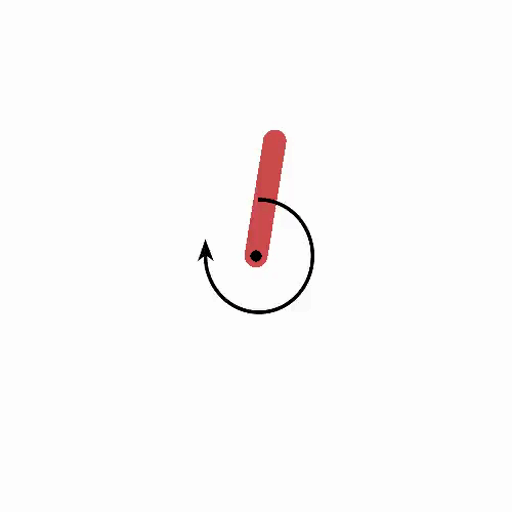
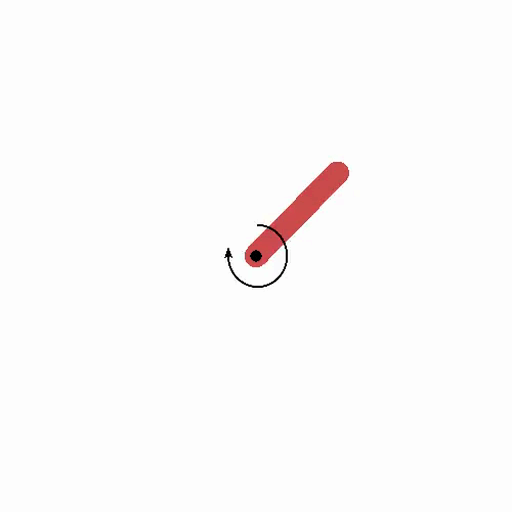
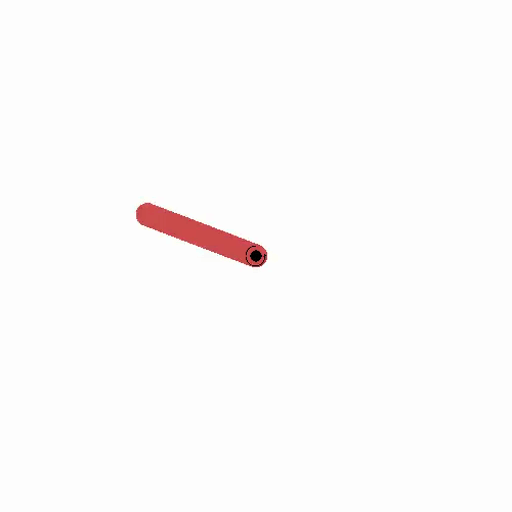
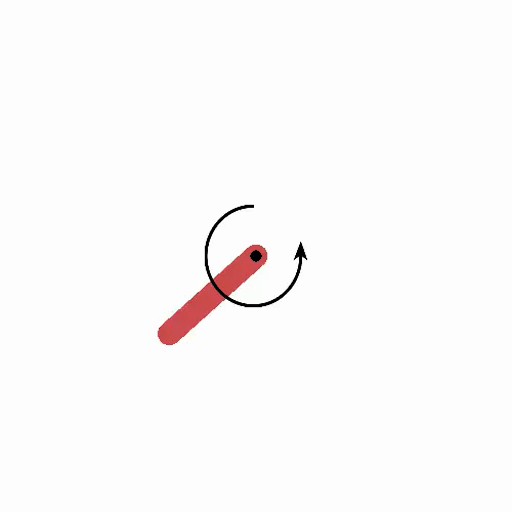

In [20]:
best_agent.demo_progression()


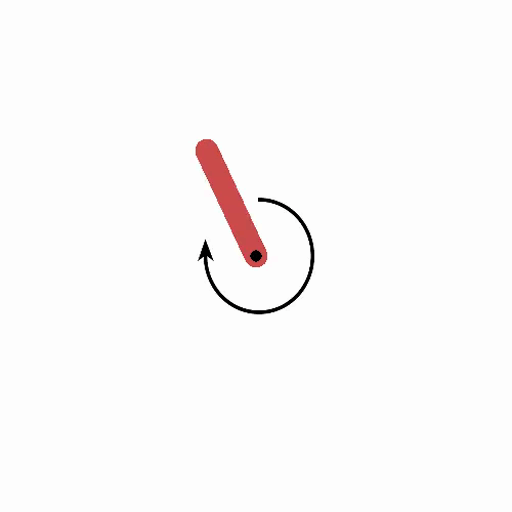
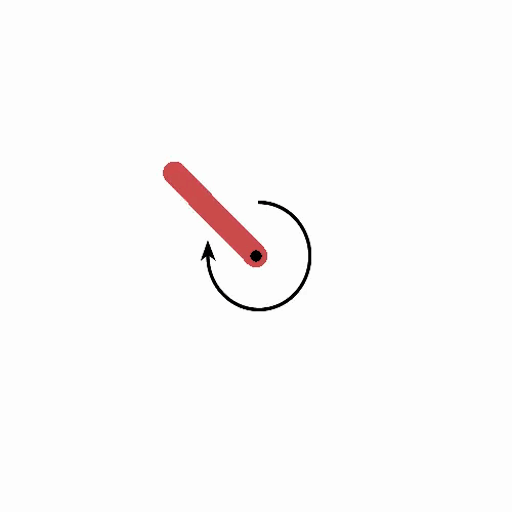

In [21]:
best_agent.demo_last()

In [22]:
ddpg_max_t, ddpg_max_r, ddpg_max_s, \
ddpg_max_sec, ddpg_max_rt = np.max(ddpg_results, axis=0).T
ddpg_min_t, ddpg_min_r, ddpg_min_s, \
ddpg_min_sec, ddpg_min_rt = np.min(ddpg_results, axis=0).T
ddpg_mean_t, ddpg_mean_r, ddpg_mean_s, \
ddpg_mean_sec, ddpg_mean_rt = np.mean(ddpg_results, axis=0).T
ddpg_x = np.arange(len(ddpg_mean_s))

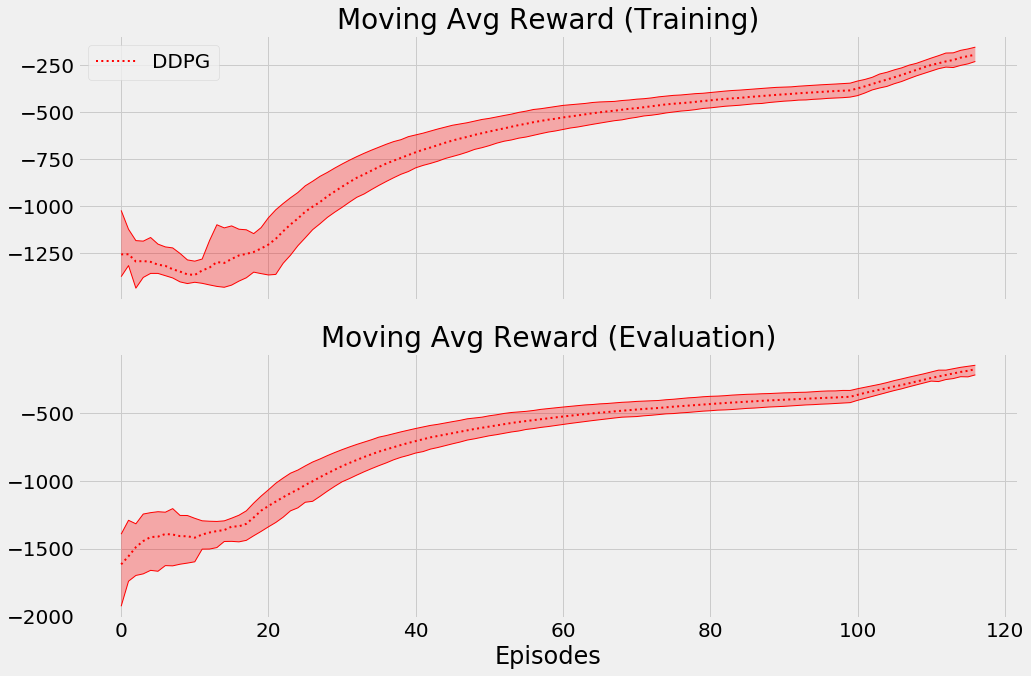

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=False, sharex=True)

# DDPG
axs[0].plot(ddpg_max_r, 'r', linewidth=1)
axs[0].plot(ddpg_min_r, 'r', linewidth=1)
axs[0].plot(ddpg_mean_r, 'r:', label='DDPG', linewidth=2)
axs[0].fill_between(
    ddpg_x, ddpg_min_r, ddpg_max_r, facecolor='r', alpha=0.3)

axs[1].plot(ddpg_max_s, 'r', linewidth=1)
axs[1].plot(ddpg_min_s, 'r', linewidth=1)
axs[1].plot(ddpg_mean_s, 'r:', label='DDPG', linewidth=2)
axs[1].fill_between(
    ddpg_x, ddpg_min_s, ddpg_max_s, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

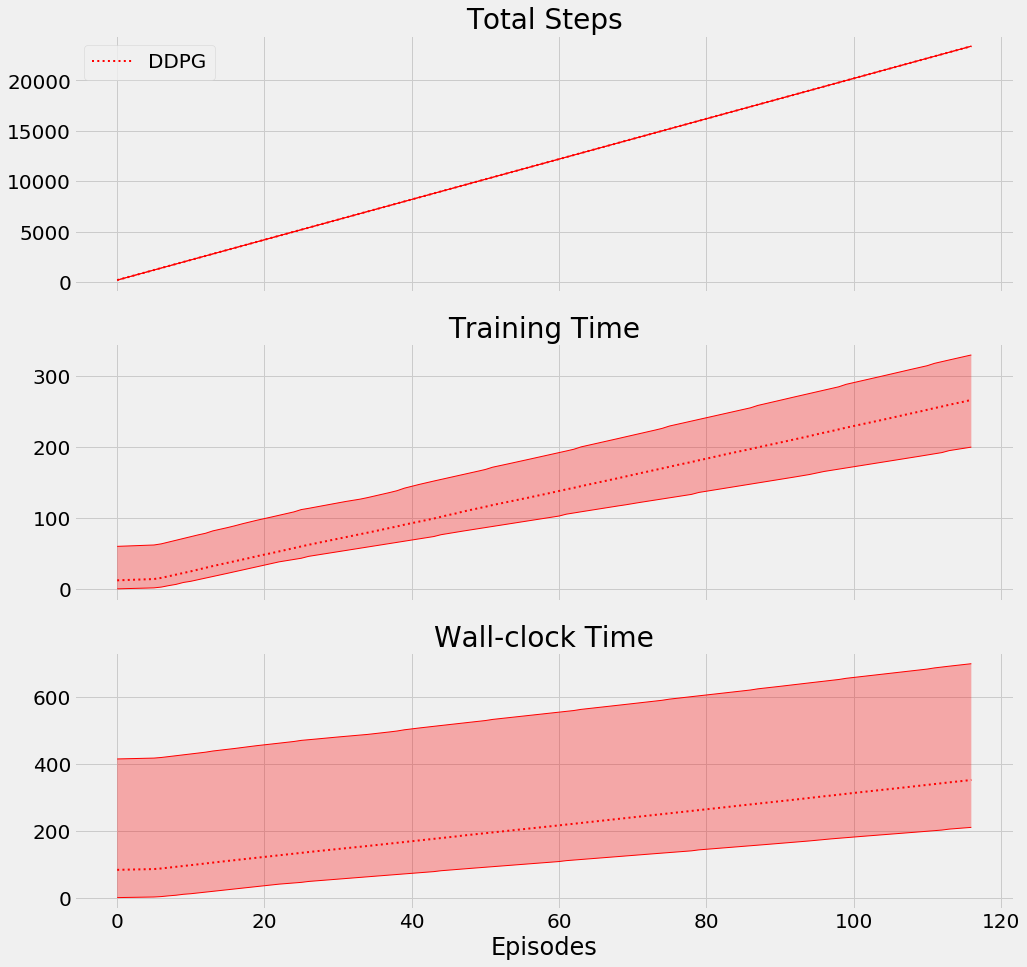

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(15,15), sharey=False, sharex=True)

# DDPG
axs[0].plot(ddpg_max_t, 'r', linewidth=1)
axs[0].plot(ddpg_min_t, 'r', linewidth=1)
axs[0].plot(ddpg_mean_t, 'r:', label='DDPG', linewidth=2)
axs[0].fill_between(
    ddpg_x, ddpg_min_t, ddpg_max_t, facecolor='r', alpha=0.3)

axs[1].plot(ddpg_max_sec, 'r', linewidth=1)
axs[1].plot(ddpg_min_sec, 'r', linewidth=1)
axs[1].plot(ddpg_mean_sec, 'r:', label='DDPG', linewidth=2)
axs[1].fill_between(
    ddpg_x, ddpg_min_sec, ddpg_max_sec, facecolor='r', alpha=0.3)

axs[2].plot(ddpg_max_rt, 'r', linewidth=1)
axs[2].plot(ddpg_min_rt, 'r', linewidth=1)
axs[2].plot(ddpg_mean_rt, 'r:', label='DDPG', linewidth=2)
axs[2].fill_between(
    ddpg_x, ddpg_min_rt, ddpg_max_rt, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Total Steps')
axs[1].set_title('Training Time')
axs[2].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

# TD3

In [ ]:
class TD3():
    def __init__(self, *args): 
        pass 

    def optimize_model(self, experiences): 
        states, actions, rewards, next_states, is_terminals = experiences 
        batch_size = len(is_terminals) 

        with torch.no_grad(): 
            a_ran = self.target_policy_model.env_max - self.update_policy_model.env_min 
            a_noise = torch.randn_like(actions)* self.policy_noise_ratio * a_ran 
            n_min = self.target_policy_model.env_min * self.policy_noise_clip_ratio 
            n_max = self.target_policy_model.env_max* self.policy_noise_clip_ratio 
            a_noise = torch.max(torch.min(a_noise, n_max), n_min)

            argmax_a_q_sp = self.target_policy_model(next_states)
            noisy_argmax_a_q_sp = argmax_a_q_sp + a_noise 
            noisy_argmax_a_q_sp = torch.max(torch.min(noisy_argmax_a_q_sp, 
                                                      self.target_policy_model.env_max),
                                            self.target_policy_model.env_min)
            
            max_q_q_sp_a, max_a_q_sb_b = self.target_value_model(next_states, noisy_argmax_a_q_sp)
            max_a_q_sp = torch.min(max_q_q_sp_a, max_a_q_sb_b)

            targ_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)

        q_sa_a, q_sa_b = self.online_value_model(states, actions)
        td_error_a = q_sa_a - target_q_sa 
        td_error_b = q_sa_b - target_q_sa 

        value_loss = td_error_a.pow(2).mul(0.5).mean() + td_error_b.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clop_grad_norm_(self.online_value_model.parameters(), 
                                       self.value_max_grad_norm)
        self.value_optimizer.step()

        if np.sum(self.episode_timestep) % self.train_policy_every_steps == 0: 
            argmax_a_q_s = self.online_policy_model(states)
            max_a_q_s = self.online_value_model.Qa(states, argmax_a_q_s)

            policy_loss = - max_a_q_s.mean()
            self.policy_optimizer.zero_grad()
            
    def interaction_step(self, state, env): 
        min_samples = self.replay_buffer.batch_size* self.n_warmup_batches 
        action = self.training_strategy.select_action(self.online_policy_model, 
                                                      state, 
                                                      len(self.replay_buffer) < min_samples)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated 
        experience = (state, action, reward, new_state, float(is_failure))

        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward 
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += self.training_strategy.ratio_noise_injected 
        return new_state, is_terminal 

    def update_value_network(self, tau = None): 
        tau = self.tau if tau is None else tau 

        for target, online in zip(self.target_value_model.parameters(), 
                                  self.online_value_model.parameters()): 
            target_ratio = (1- tau)* target.data 
            online_ratio = tau*online.data 
            mixed_ratio = target_ratio + online_ratio 
            target.data.copy_(online)

    def update_policy_network(self, tau = None): 
        tau = self.tau if tau is None else tau 

        for target, online in zip(self.target_policy_model.parameters(), 
                                  self.online_policy_model.parameters()): 
            target_ratio = (1.0 - tau)*target.data 
            online_ratio = tau*online.data 
            mixed_weights = target_ratio + online_ratio 
            target.data.copy_(mixed_weights)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward): 
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn 
        self.make_env_kargs = make_env_kargs 
        self.seed = seed 
        self.gamma = gamma 

        env = self.make_env_fn(**self.make_env_kargs, seed = self.seed)
        torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

        nS, nA = env.observation_space.shape[0], env.action_shape.shape[0]
        action_bounds = env.action_space.low, env.action_space.high 

        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []
        self.episode_exploration = []


        self.target_value_model = self.value_model_fn(nS, nA)
        self.online_value_model = self.value_model_fn(nS, nA)
        self.update_value_model(tau = 1.0)

        self.target_policy_model = self.policy_model_fn(nS, action_bounds)
        self.online_policy_model = self.policy_model_fn(nS, action_bounds)
        self.update_policy_network(tau= 1.0)

        self.value_optimizer = self.value_optimizer_fn(self.online_value_model, 
                                                       self.value_optimizer_lr)
        self.policy_optimizer = self.policy_optimizer_fn(self.online_policy_model, 
                                                         self.policy_optimizer_lr)
        
        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn(action_bounds)
        self.evaluation_strategy = evaluation_strategy_fn(action_bounds)

        result = np.empty((max_episodes, 5))
        result[:] = np.nan 

        training_time = 0  
        for episode in range(1, max_episodes+1):
            episode_start = time.time()

            state, is_terminal = env.reset(), False 
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count(): 
                state, is_terminal = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches 

                if len(self.replay_buffer) > min_samples: 
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model.load(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_value_target_every_steps == 0: 
                    self.update_value_network()
                if np.sum(self.episode_timestep) % self.update_policy_target_every_steps == 0: 
                    self.update_policy_network()

                if is_terminal: 
                    gc.collect()
                    break 

            # stats 
            episode_elapsed = time.time() - episode_start 
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed

            evaluation_score, _ = self.evaluate(self.online_policy_model, env)
            self.save_checkpoint(episode -1, self.online_policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)

            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:]
            )/ np.array(self.episode_timestep[-100:])

            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)


            wallclock_elapsed = time.time() - training_start 
            result[episode -1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed 
            

            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes* 60 
            reached_max_episodes = episode >= max_episodes 
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward 
            training_is_over = reached_max_minutes or \
                                    reached_max_episodes or \
                                    reached_goal_mean_reward 
            
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:07}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            
            print(debug_message, end = '\r', flush= True)
            if reached_debug_time or training_is_over: 
                print(ERASE_LINE + debug_message, flush = True)
                last_debug_time = time.time()
            if training_is_over: 
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
        final_eval_score, score_std = self.evaluate(self.online_policy_model, env, n_episodes= 100)
        wallclock_time = time.time() - training_start 

        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env

        self.get_cleaned_checkpionts()
        return result, final_eval_score, training_time, wallclock_time 


    def evaluate(self, eval_policy_model, eval_env, n_episodes = 1):
        rs = []

        for _ in range(n_episodes): 
            s, d = eval_env.reset(), False 
            rs.append(0)
            for _ in count(): 
                a = self.evaluation_strategy.select_action(eval_policy_model, s) 
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r 
                if d: break 
        return np.mean(rs), np.std(rs) 

    def get_cleaned_checkpionts(self, n_checkpoints = 4): 
        try:
            return self.checkpoint_paths 
        except AttributeError: 
            self.checkpoint_paths = {}
        
        paths = glob.glob(os.path.join(self.checkpoint_paths, "*.tar"))
        paths_dic = {int(path.split.(".")[-2]): path for path in paths}
        last_ep = max(paths_dic.keys())

        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint = True, dtype = np.int)

        for idx, path in paths_dic.item(): 
            if idx in checkpoint_idxs: 
                self.checkpoint_paths[idx] = path 
            else: 
                os.unlink(path)
        return self.checkpoint_paths 

    def demo_last(self, title = 'Fully-trained {} Agent', n_episodes = 2, max_n_videos= 2): 
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode = "evaluation", render = True)

        checkpoint_paths = self.get_cleaned_checkpionts()
        last_ep = max(checkpoint_paths.keys())

        self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.online_policy_model, env, n_episodes= n_episodes)
        env.close()
        data = get_gif_html(env_videos = env.videos, 
                            title = titile.format(self.__class__.__name__), 
                            max_n_videos= max_n_videos)
        
        del env 
        return HTML(data = data)


    def demo_progression(self, title = "{} Agent progression", max_n_videos = 4): 
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode = 'evaluation', render = True, record = True)

        checkpoint_paths = self.get_cleaned_checkpionts()
        for i in sorted(checkpoint_paths.keys()):
            self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.online_policy_model, env, n_episodes= 1)

        env.close()

        data = get_gif_html(env_videos= env.videos, 
                            title = title.format(self.__class__.__name__),
                            subtitle_eps= = sorted(checkpoint_paths.keys()),
                            max_n_videos= max_n_videos)
        
        del env 
        return HTML(data = data)


    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 
                                'model.{}.tar'.format(episode_idx)))


SyntaxError: invalid syntax (<ipython-input-25-98abe88a6ba3>, line 105)